In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from  matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from datetime import datetime
import os
import pickle
import seaborn

In [32]:
%matplotlib inline
seaborn.set(rc={'figure.figsize':(15,8)})
seaborn.set(font_scale=1.2)

In [33]:
TIME_START = "20170101"
TIME_END = "20201231"

In [34]:
def convert_timestamp(string_time):
    temp_time = string_time.split()
    if temp_time[1] == 'mei':
        temp_time[1] = 'may'
    elif temp_time[1] == 'ags':
        temp_time[1] = 'aug'
    elif temp_time[1] == 'okt':
        temp_time[1] = 'oct'
    elif temp_time[1] == 'des':
        temp_time[1] = 'dec'
    fixed_string_time = " ".join(temp_time)
    datetime_obj = datetime.strptime(
        fixed_string_time, "%d %b %Y"
    )
    return datetime_obj.strftime('%Y%m%d')

stock_time_data = dict()
with open('../data/listing_date.csv', 'r') as file:
    reader = csv.reader(file, delimiter='|')
    for row in reader:
        row[2] = convert_timestamp(row[2])
        stock_time_data[row[0]] = row[2]

In [35]:
dump_file = open("../data/stock_price.obj", "rb")
price_list = pickle.load(dump_file)
price_list = {idx: gp.xs(idx, level=0, axis=1).dropna()
              for idx, gp in price_list.groupby(level=0, axis=1)}

In [36]:
def get_output(foldername):
    invalid = []

    df_overall = [None for i in range(5)]
    for filename in tqdm(os.listdir(f'../{foldername}/')):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(f'../{foldername}/', filename), index_col=0)
            if(df.loc[1, 'max'] == 0 or df.loc[1].isnull().values.any()):
                invalid.append(filename.split('.')[0])
                continue
            for index, row in df.iterrows():
                if(df.loc[index, 'max'] != 0 and not df.loc[index].isnull().values.any()):
                    if type(df_overall[index]) == type(None):
                        df_overall[index] = df.loc[index]
                    else:
                        df_overall[index] = pd.concat([df_overall[index], df.loc[index]])

    for idx, df in enumerate(df_overall):
        if type(df) != type(None):
            max_df = df[['max']].reset_index(drop=True)
            min_df = df[['min']].reset_index(drop=True)
            avg_df = df[['avg']].reset_index(drop=True)
            median_df = df[['median']].reset_index(drop=True)
            count_df = df[['count']].reset_index(drop=True)
            df_overall[idx] = pd.concat([
                max_df,
                min_df,
                avg_df,
                median_df,
                count_df
            ], ignore_index=True, axis=1).rename(columns={0: 'max', 1: 'min', 2: 'avg', 3: 'median', 4: 'count'})
    
    return df_overall, invalid

def get_differences(df):
    mean_data = [df[i][['avg']] for i in range(4)]
    temp = [[], []]
    for i in range(len(mean_data[0])):
        for j in range(2):
            temp[j].append(mean_data[j+1].loc[i, 'avg'] - mean_data[j].loc[i, 'avg'])
    return mean_data, temp

In [37]:
def check_invalid(invalid):
    if(len(invalid) == 0):
        print("No invalid data")
    else:
        print(sorted(
        [(i, stock_time_data[i], len(price_list[f'{i}.JK'][TIME_START:TIME_END].Close)) for i in invalid],
        key=lambda k: k[1]
        ))

# Graph-Subset

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 703/703 [00:07<00:00, 92.84it/s]


[('ZBRA', '19910801', 220), ('BCIC', '19970625', 4), ('YULE', '20041210', 669), ('YPAS', '20080305', 489)]


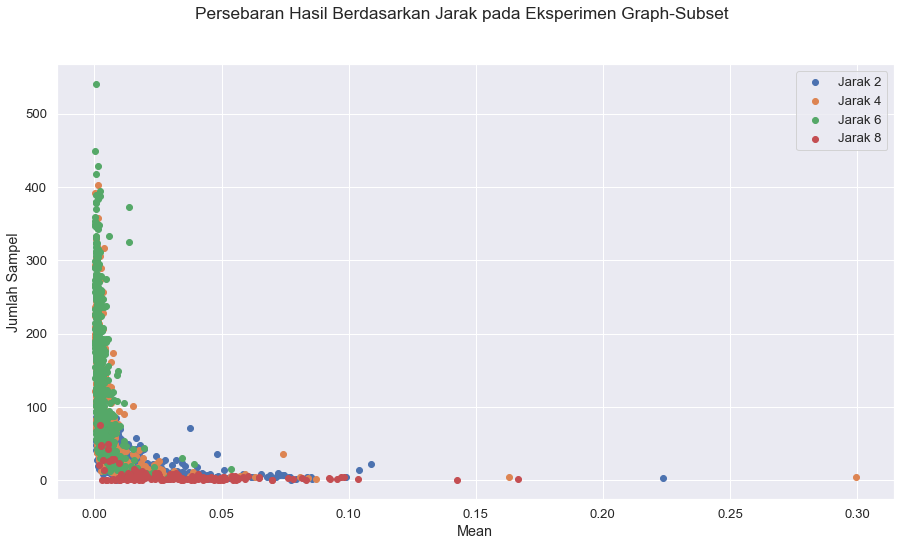

In [38]:
foldername = 'output/output_subset_val/stock_return'
df_output_subset_val, invalid = get_output(foldername)
check_invalid(invalid)
for i in range(4):
    plt.scatter(x = df_output_subset_val[i][['avg']],
                y = df_output_subset_val[i][['count']],
                label=f"Jarak {i*2+2}"
               )
    plt.legend()
    plt.xlabel('Mean')
    plt.ylabel('Jumlah Sampel')
    plt.suptitle('Persebaran Hasil Berdasarkan Jarak pada Eksperimen Graph-Subset')
    plt.savefig('../img/stock-result/subset_val-scatter.png', bbox_inches='tight')

# Naive-All

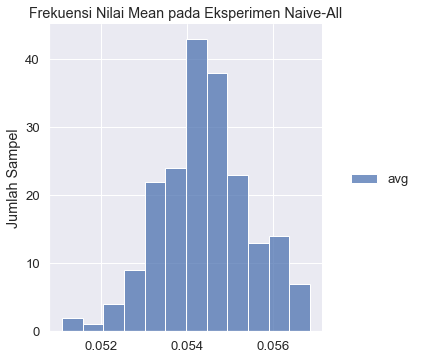

In [39]:
df_output_all_naive = pd.read_csv('../output/output_all_naive/overall_mean_return.csv', index_col=0)
seaborn.displot(
    data=df_output_all_naive[['avg']]
).set(
    title='Frekuensi Nilai Mean pada Eksperimen Naive-All',
    ylabel="Jumlah Sampel"
).savefig('../img/stock-result/all_naive-dist.png', bbox_inches='tight')

In [40]:
df_output_all_naive[['avg']].mean()

avg    0.054419
dtype: float64

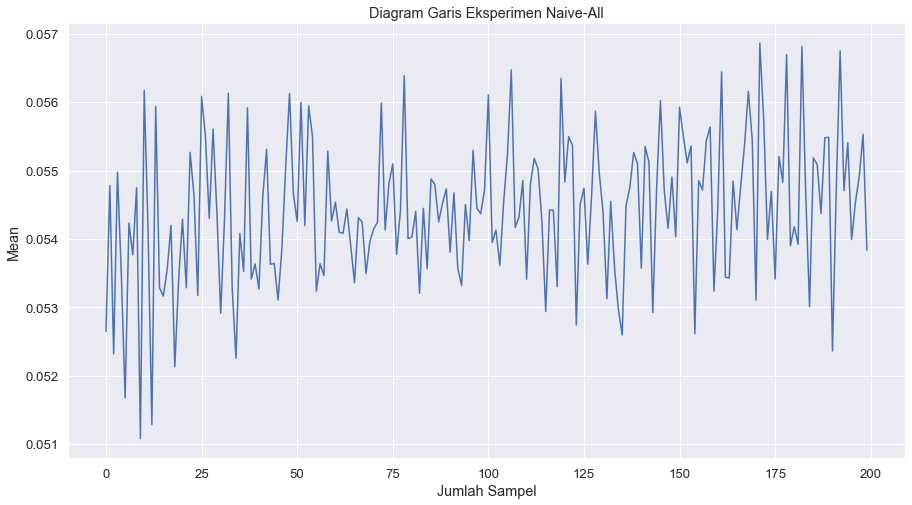

In [41]:
all_naive_lineplot = seaborn.lineplot(
    data = df_output_all_naive[['avg']].reset_index().rename(
        columns={"index": 'count'}
    ),
    x = 'count',
    y = 'avg'
).set(
    title='Diagram Garis Eksperimen Naive-All',
    xlabel='Jumlah Sampel',
    ylabel='Mean'
)

plt.savefig('../img/stock-result/all_naive-line.png', bbox_inches='tight')

# Naive-Subset

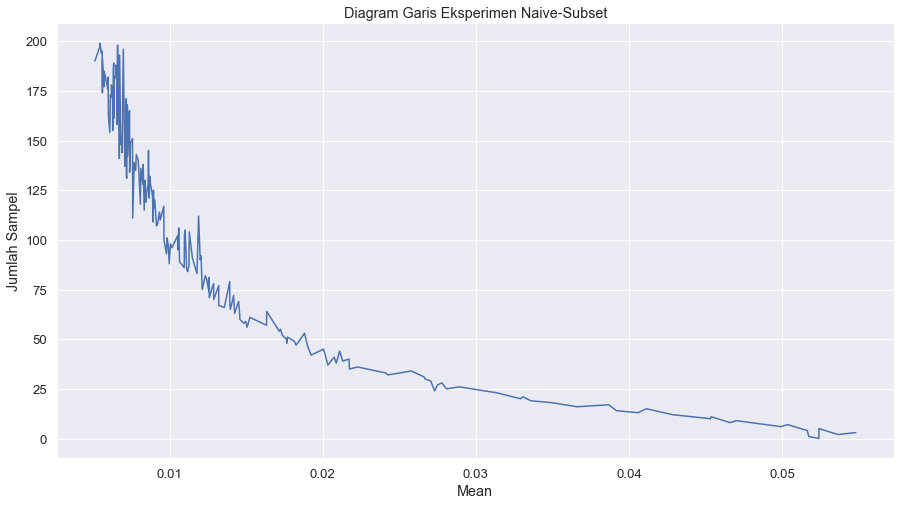

In [42]:
df_output_subset_naive = pd.read_csv('../output/output_subset_naive/overall_mean_return.csv', index_col=0)
seaborn.lineplot(
    data=df_output_subset_naive[['avg']]
    .reset_index()
    .rename(
        columns={"index": 'count'}
    ),
    x = 'avg',
    y = 'count'
).set(
    xlabel='Mean',
    ylabel="Jumlah Sampel",
    title='Diagram Garis Eksperimen Naive-Subset'
)

plt.savefig('../img/stock-result/subset_naive-line.png', bbox_inches='tight')

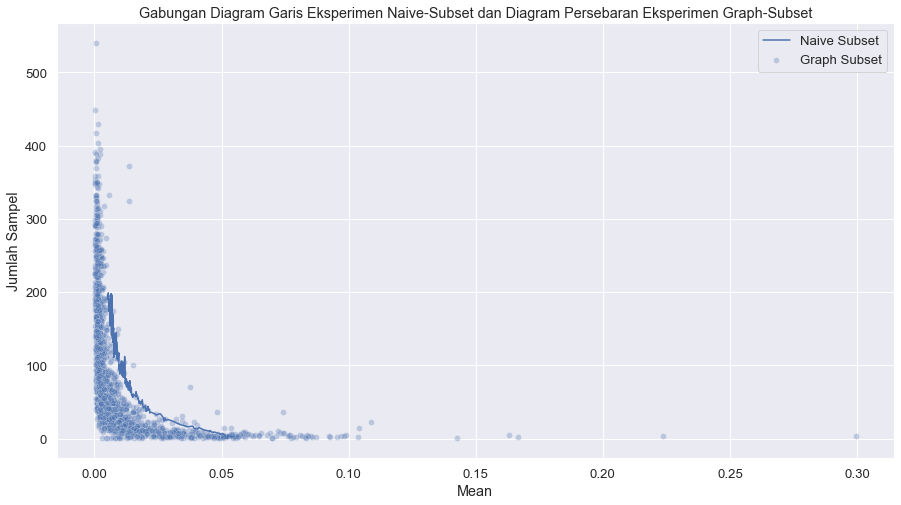

In [43]:
def generate_merged_plot_1(ax=None):
    merged_df = pd.concat([df_output_subset_val[0], df_output_subset_val[1], df_output_subset_val[2], df_output_subset_val[3]])
    lineplot_params = {
        'data': df_output_subset_naive[['avg']].reset_index().rename(columns={"index": 'count'}),
        'x': 'avg',
        'y': 'count',
        'label': 'Naive Subset'
    }   
    scatterplot_params = {
        'data': merged_df,
        'x': 'avg',
        'y': 'count',
        'alpha': 0.3,
        'label': 'Graph Subset'
    }
    if(ax is not None):
        lineplot_params['ax'] = ax
        scatterplot_params['ax'] = ax
    seaborn.lineplot(**lineplot_params)
    seaborn.scatterplot(
        **scatterplot_params
    ).set(
        xlabel='Mean',
        ylabel='Jumlah Sampel',
        title='Gabungan Diagram Garis Eksperimen Naive-Subset dan Diagram Persebaran Eksperimen Graph-Subset'
    )

generate_merged_plot_1()
plt.savefig('../img/stock-result/subset_naive-line-merged.png', bbox_inches='tight')

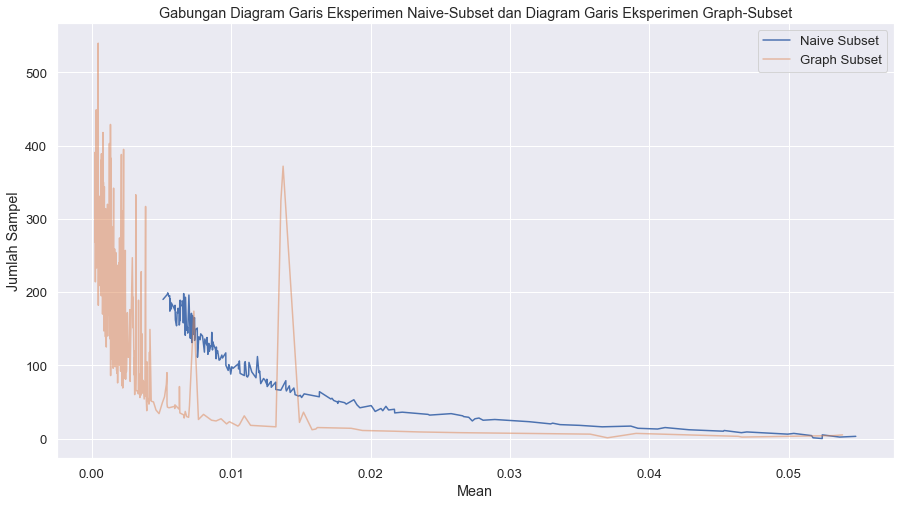

In [44]:
def generate_merged_plot_2(ax=None):
    merged_df = pd.concat([df_output_subset_val[0], df_output_subset_val[1], df_output_subset_val[2], df_output_subset_val[3]])
    merged_df = merged_df.groupby(by=['count']).mean()

    lineplot_params_1 = {
        'data': df_output_subset_naive[['avg']].reset_index().rename(columns={"index": 'count'}),
        'x': 'avg',
        'y': 'count',
        'label': 'Naive Subset'
    }
    lineplot_params_2 = {
        'data': merged_df,
        'x': 'avg',
        'y': 'count',
        'alpha': 0.5,
        'label': 'Graph Subset'
    }
    if(ax is not None):
        lineplot_params_1['ax'] = ax
        lineplot_params_2['ax'] = ax

    seaborn.lineplot(**lineplot_params_1)

    seaborn.lineplot(
        **lineplot_params_2
    ).set(
        xlabel='Mean',
        ylabel='Jumlah Sampel',
        title='Gabungan Diagram Garis Eksperimen Naive-Subset dan Diagram Garis Eksperimen Graph-Subset'
    )

generate_merged_plot_2()

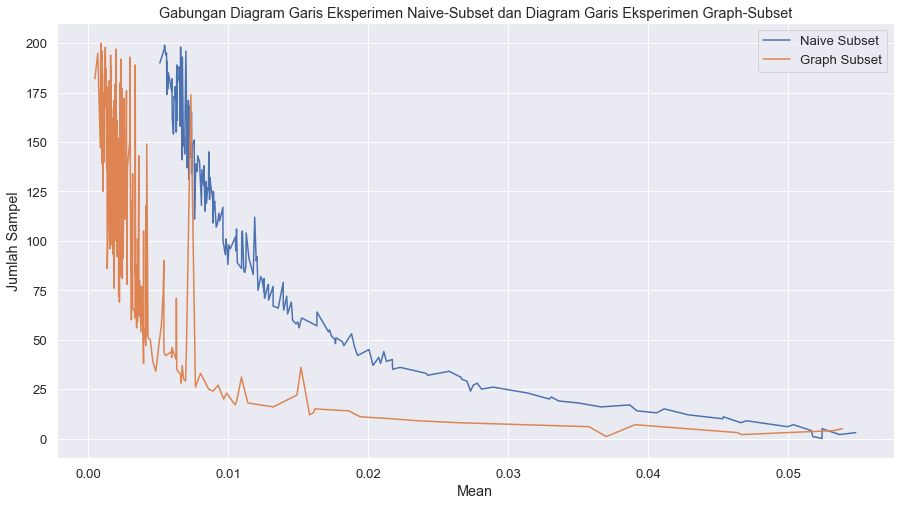

In [45]:
def generate_merged_plot_3(ax=None):
    merged_df = pd.concat([df_output_subset_val[0], df_output_subset_val[1], df_output_subset_val[2], df_output_subset_val[3]])
    merged_df = merged_df.groupby(by=['count']).mean().reset_index()

    lineplot_params_1 = {
        'data': df_output_subset_naive[['avg']].reset_index().rename(columns={"index": 'count'}),
        'x': 'avg',
        'y': 'count',
        'label': 'Naive Subset'
    }
    lineplot_params_2 = {
        'data': merged_df[merged_df['count'] <= 200],
        'x': 'avg',
        'y': 'count',
        'label': 'Graph Subset'
    }
    if(ax is not None):
        lineplot_params_1['ax'] = ax
        lineplot_params_2['ax'] = ax

    seaborn.lineplot(**lineplot_params_1)

    seaborn.lineplot(
        **lineplot_params_2
    ).set(
        xlabel='Mean',
        ylabel='Jumlah Sampel',
        title='Gabungan Diagram Garis Eksperimen Naive-Subset dan Diagram Garis Eksperimen Graph-Subset'
    )

generate_merged_plot_3()
plt.savefig('../img/stock-result/subset_naive-mean-line.png', bbox_inches='tight')

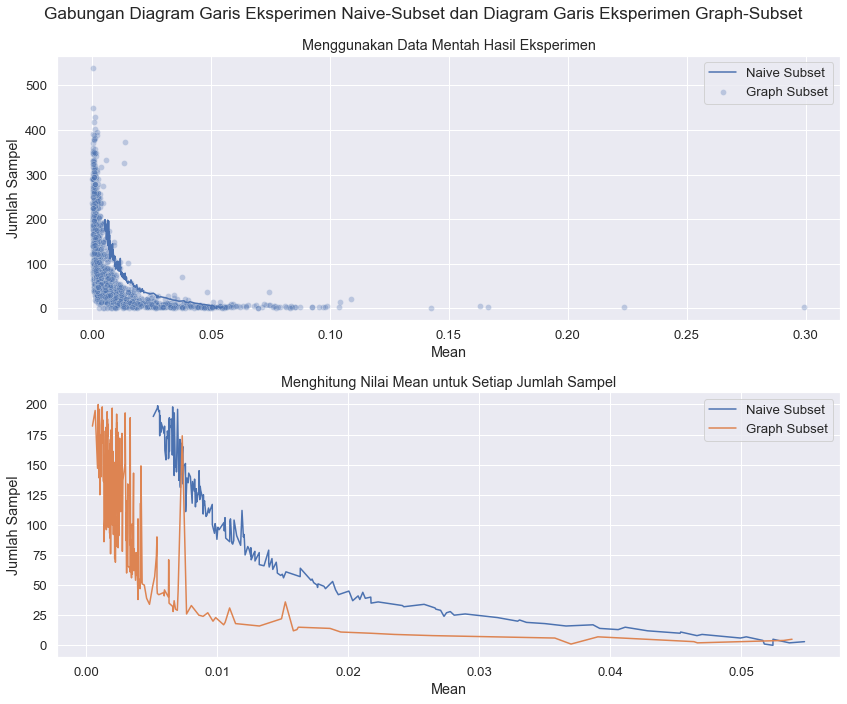

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Gabungan Diagram Garis Eksperimen Naive-Subset dan Diagram Garis Eksperimen Graph-Subset')
generate_merged_plot_1(axes[0])
generate_merged_plot_3(axes[1])
axes[0].title.set_text('Menggunakan Data Mentah Hasil Eksperimen')
axes[1].title.set_text('Menghitung Nilai Mean untuk Setiap Jumlah Sampel')

fig.tight_layout()
plt.savefig('../img/stock-result/subset_naive-mean-line.png', bbox_inches='tight')

Mean Difference   -0.682077
dtype: float64


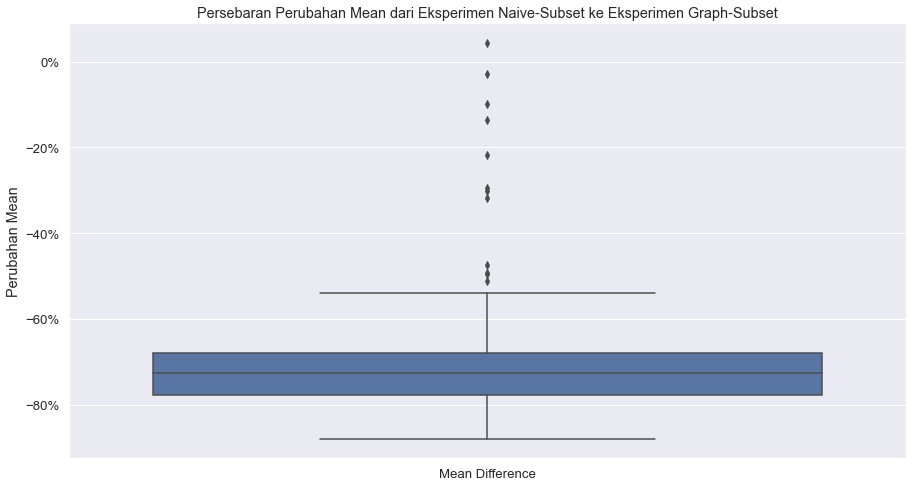

In [47]:
def plot_difference_percentage():
    merged_df = pd.concat([df_output_subset_val[0], df_output_subset_val[1], df_output_subset_val[2], df_output_subset_val[3]])
    merged_df = merged_df.groupby(by=['count']).mean().reset_index()
    divided_df = (merged_df[merged_df['count'] <= 100][['avg']] - df_output_subset_naive[['avg']]) / df_output_subset_naive[['avg']]
    divided_df.index = divided_df.index + 1
    divided_df = divided_df.reset_index().rename(
            columns={"avg": "Mean Difference"}
    )

    ax = seaborn.boxplot(
        data=divided_df[['Mean Difference']]
    )

    ax.set(
        ylabel='Perubahan Mean',
        title='Persebaran Perubahan Mean dari Eksperimen Naive-Subset ke Eksperimen Graph-Subset'
    )

    ax.yaxis.set_major_formatter(PercentFormatter(1))
    print(divided_df[['Mean Difference']].mean())

plot_difference_percentage()
plt.savefig('../img/stock-result/subset_naive-mean-percentdiff-line.png', bbox_inches='tight')

Mean Difference   -0.682077
dtype: float64


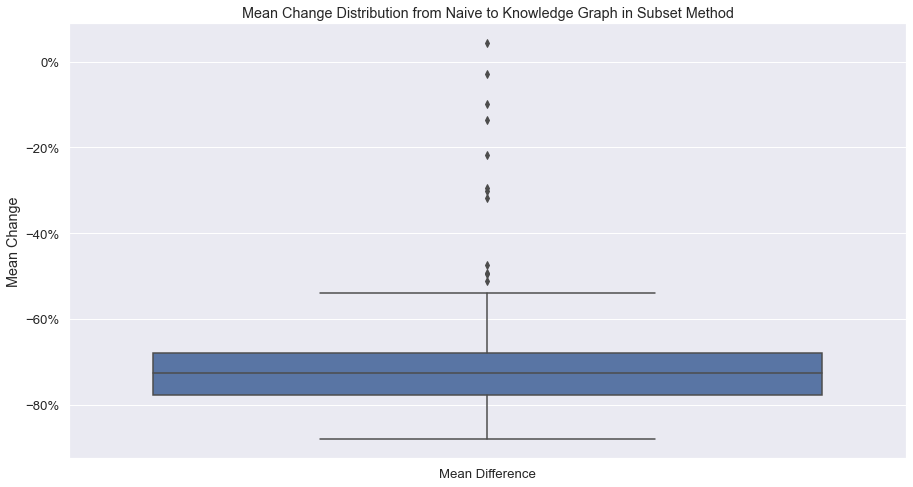

In [48]:
def plot_difference_percentage():
    merged_df = pd.concat([df_output_subset_val[0], df_output_subset_val[1], df_output_subset_val[2], df_output_subset_val[3]])
    merged_df = merged_df.groupby(by=['count']).mean().reset_index()
    divided_df = (merged_df[merged_df['count'] <= 100][['avg']] - df_output_subset_naive[['avg']]) / df_output_subset_naive[['avg']]
    divided_df.index = divided_df.index + 1
    divided_df = divided_df.reset_index().rename(
            columns={"avg": "Mean Difference"}
    )

    ax = seaborn.boxplot(
        data=divided_df[['Mean Difference']]
    )

    ax.set(
        ylabel='Mean Change',
        title='Mean Change Distribution from Naive to Knowledge Graph in Subset Method'
    )

    ax.yaxis.set_major_formatter(PercentFormatter(1))
    print(divided_df[['Mean Difference']].mean())

plot_difference_percentage()
plt.savefig('../img/stock-result/subset_naive-mean-percentdiff-line-en.png', bbox_inches='tight')

# Graph-All

In [49]:
foldername = 'output/output_all_val/stock_return'
df_output_all_val, invalid = get_output(foldername)
check_invalid(invalid)
for i in range(4):
    print(len(df_output_all_val[i]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 703/703 [00:13<00:00, 51.00it/s]


[('ZBRA', '19910801', 220), ('BCIC', '19970625', 4), ('YULE', '20041210', 669), ('YPAS', '20080305', 489)]
698
699
699
132


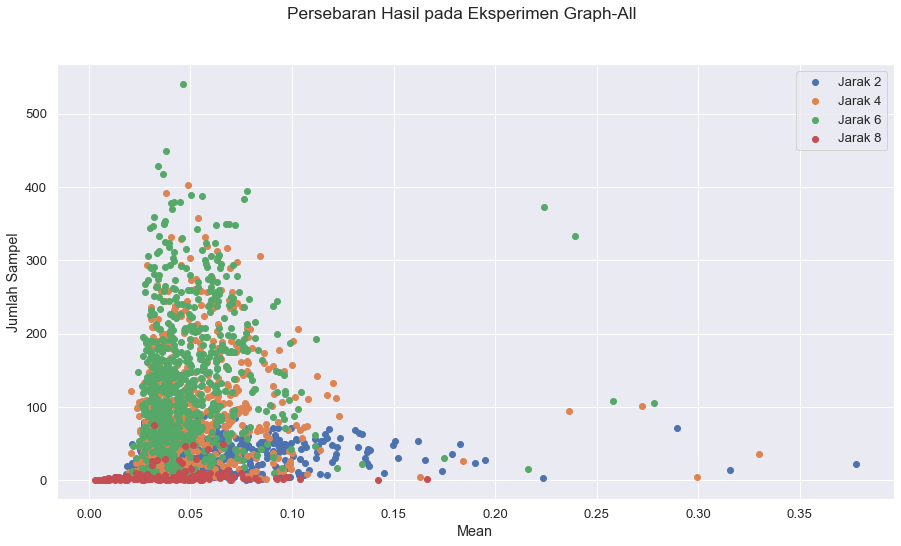

In [50]:
for i in range(4):
    plt.scatter(
        x = df_output_all_val[i][['avg']],
        y = df_output_all_val[i][['count']],
        label=f"Jarak {i*2+2}"
    )
    plt.legend()
    plt.xlabel('Mean')
    plt.ylabel('Jumlah Sampel')
    
plt.suptitle('Persebaran Hasil pada Eksperimen Graph-All')
plt.savefig('../img/stock-result/all_val-scatter.png', bbox_inches='tight')

Mean
avg    0.055947
dtype: float64 avg    0.050835
dtype: float64 avg    0.049943
dtype: float64 avg    0.044348
dtype: float64
avg   -9.136852
dtype: float64
avg   -1.754556
dtype: float64
avg   -11.203215
dtype: float64
Median
avg    0.046247
dtype: float64 avg    0.043027
dtype: float64 avg    0.043776
dtype: float64 avg    0.044132
dtype: float64
avg   -6.962437
dtype: float64
avg    1.740861
dtype: float64
avg    0.811684
dtype: float64


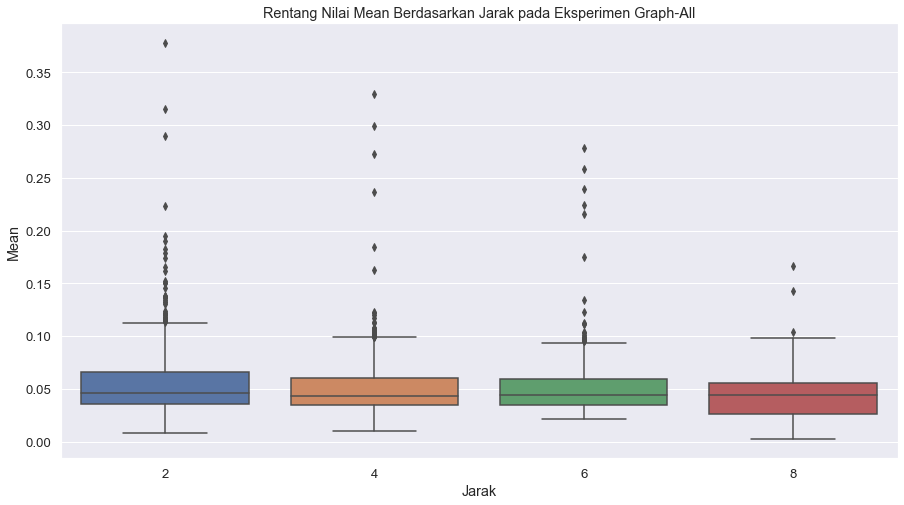

In [51]:
mean_data, differences_data = get_differences(df_output_all_val)
print('Mean')
print(mean_data[0].mean(), mean_data[1].mean(), mean_data[2].mean(), mean_data[3].mean())
for i in range(3):
    print((mean_data[i+1].mean()/mean_data[i].mean() - 1) * 100)
print('Median')
print(mean_data[0].median(), mean_data[1].median(), mean_data[2].median(), mean_data[3].median())
for i in range(3):
    print((mean_data[i+1].median()/mean_data[i].median() - 1) * 100)
seaborn.boxplot(
    data=mean_data
).set(
    xlabel='Jarak',
    ylabel='Mean',
    title='Rentang Nilai Mean Berdasarkan Jarak pada Eksperimen Graph-All',
)
plt.xticks([0, 1, 2, 3], [2, 4, 6, 8])
plt.savefig('../img/stock-result/all_val_mean-box.png', bbox_inches='tight')

In [52]:
df_output_all_val

[          max       min       avg    median  count
 0    0.645450  0.002098  0.132727  0.110482   45.0
 1    0.098096  0.000457  0.036183  0.030562   34.0
 2    0.147509  0.001608  0.050823  0.045482   49.0
 3    0.121073  0.002874  0.048460  0.043563   24.0
 4    0.212763  0.005074  0.073125  0.063144   29.0
 ..        ...       ...       ...       ...    ...
 693  0.655495  0.000704  0.150676  0.091182   54.0
 694  0.555971  0.000724  0.093296  0.061333   71.0
 695  0.090309  0.000676  0.049093  0.047447    8.0
 696  0.098426  0.000878  0.029094  0.021173   14.0
 697  0.172958  0.000382  0.056279  0.038200   14.0
 
 [698 rows x 5 columns],
           max       min       avg    median  count
 0    0.194333  0.000511  0.073444  0.064370  179.0
 1    0.090840  0.000100  0.034402  0.033016   90.0
 2    0.247053  0.004938  0.068019  0.058152   88.0
 3    0.114267  0.000700  0.038117  0.033030   83.0
 4    0.229522  0.000061  0.076857  0.068420   93.0
 ..        ...       ...       ...   

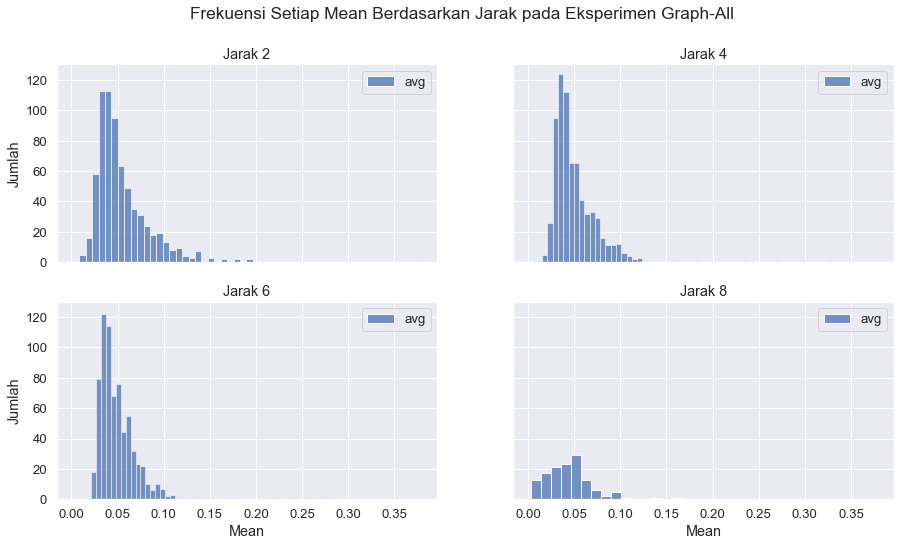

In [53]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Frekuensi Setiap Mean Berdasarkan Jarak pada Eksperimen Graph-All')
for i in range(4):
    seaborn.histplot(ax = axes[i//2, i%2], data=mean_data[i])
    axes[i//2, i%2].set_title(f"Jarak {i*2 + 2}")
    axes[i//2, i%2].set(xlabel="Mean", ylabel="Jumlah")
plt.savefig('../img/stock-result/all_val_mean-distribution.png', bbox_inches='tight')

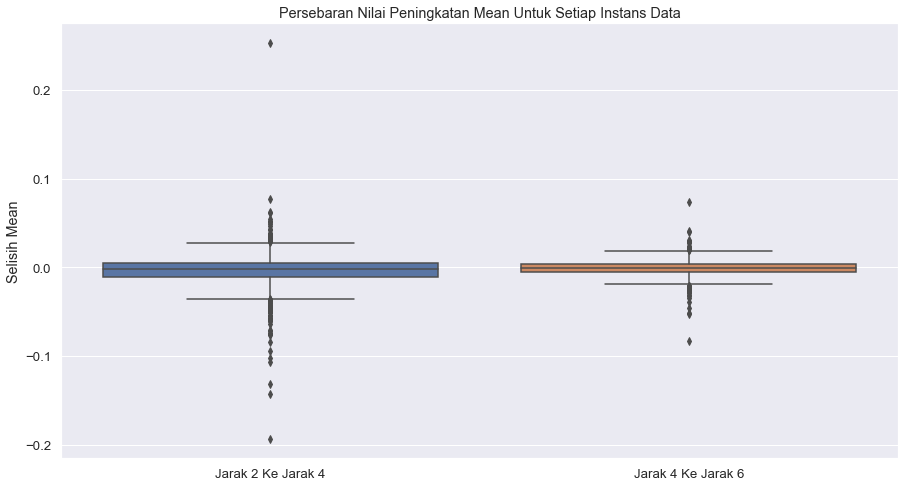

In [54]:
seaborn.boxplot(
    data=differences_data
).set(
    ylabel='Selisih Mean',
    title='Persebaran Nilai Peningkatan Mean Untuk Setiap Instans Data'
)
plt.xticks([0, 1], ['Jarak 2 Ke Jarak 4', 'Jarak 4 Ke Jarak 6'])
plt.savefig('../img/stock-result/all_val_differences-box.png', bbox_inches='tight')

In [55]:
print(np.mean(differences_data[0]))
print(np.mean(differences_data[1]))

-0.005095017559315045
-0.0009180464884960222


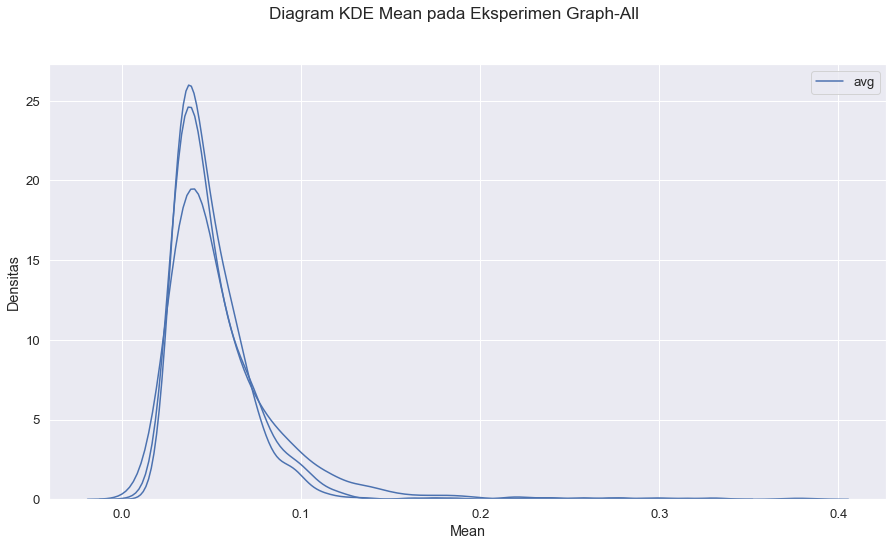

In [56]:
seaborn.kdeplot(data=mean_data[0])
seaborn.kdeplot(data=mean_data[1])
seaborn.kdeplot(data=mean_data[2])
plt.ylabel('Densitas')
plt.xlabel('Mean')
plt.suptitle('Diagram KDE Mean pada Eksperimen Graph-All')
plt.savefig('../img/stock-result/all_val_mean-displot.png', bbox_inches='tight')

# Graph-Random

In [57]:
foldername = 'output/output_random_val'
df_output_random_val, invalid = get_output(foldername)
check_invalid(invalid)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:07<00:00, 89.92it/s]

No invalid data


avg    0.423409
dtype: float64 avg    0.414412
dtype: float64 avg    0.41578
dtype: float64


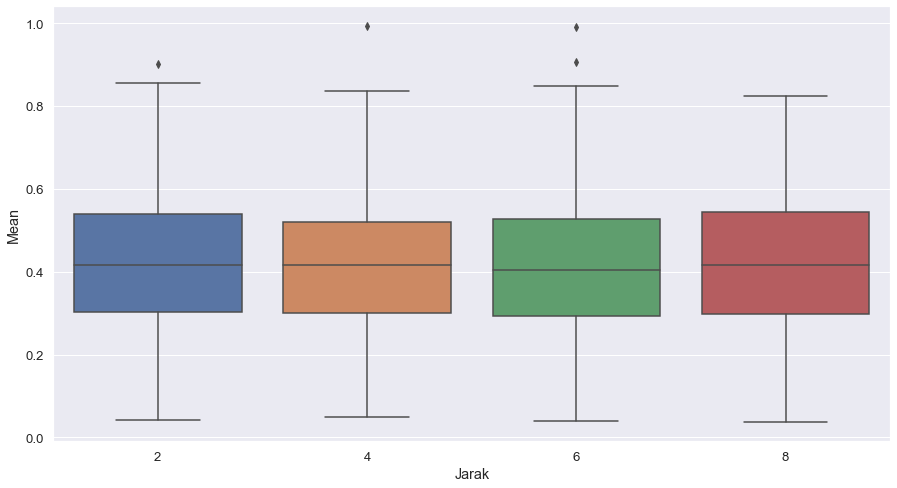

In [58]:
mean_data, differences_data = get_differences(df_output_random_val)
print(mean_data[0].mean(), mean_data[1].mean(), mean_data[2].mean())

seaborn.boxplot(
    data=mean_data
).set(
    xlabel='Jarak',
    ylabel='Mean',
    xticklabels=[2, 4, 6, 8]
)
plt.savefig('../img/stock-result/random_val_mean-box.png', bbox_inches='tight')

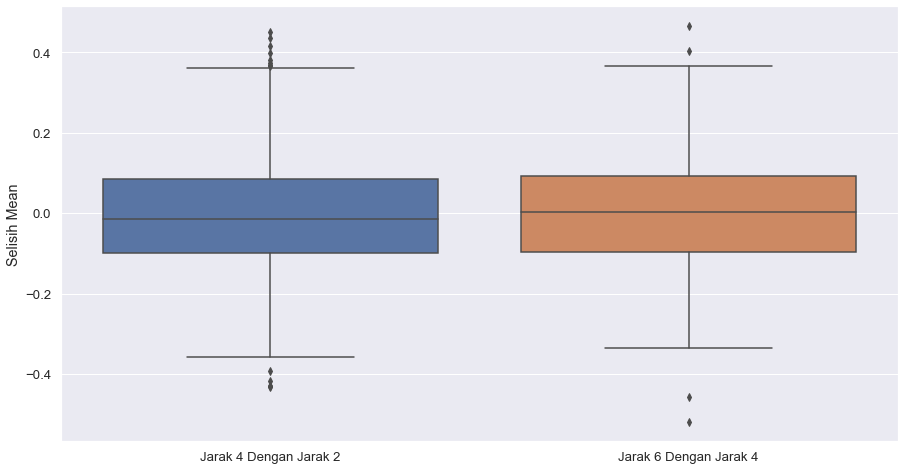

In [59]:
seaborn.boxplot(data=differences_data)
plt.xticks([0, 1], ['Jarak 4 Dengan Jarak 2', 'Jarak 6 Dengan Jarak 4'])
plt.ylabel('Selisih Mean')
plt.savefig('../img/stock-result/random_val_differences-box.png')

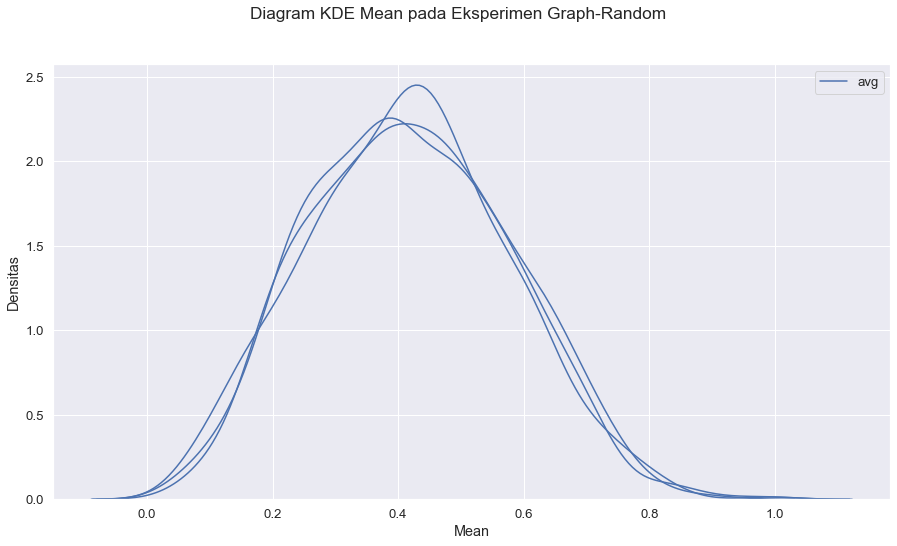

In [60]:
seaborn.kdeplot(data=mean_data[0])
seaborn.kdeplot(data=mean_data[1])
seaborn.kdeplot(data=mean_data[2])
plt.ylabel('Densitas')
plt.xlabel('Mean')

plt.suptitle('Diagram KDE Mean pada Eksperimen Graph-Random')
plt.savefig('../img/stock-result/random_val_mean-displot.png')